# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Determinación-de-los-parámetros-de-los-retardadores" data-toc-modified-id="Determinación-de-los-parámetros-de-los-retardadores-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Determinación de los parámetros de los retardadores</a></div><div class="lev2 toc-item"><a href="#Parte-experimental" data-toc-modified-id="Parte-experimental-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Parte experimental</a></div><div class="lev2 toc-item"><a href="#Parte-numérica" data-toc-modified-id="Parte-numérica-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Parte numérica</a></div><div class="lev2 toc-item"><a href="#Definición-de-funcion-de-ajuste" data-toc-modified-id="Definición-de-funcion-de-ajuste-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Definición de funcion de ajuste</a></div>

# Determinación de los parámetros de los retardadores

**Autor**: Luis Miguel Sanchez Brea

**Fecha**:   12/03/2018

**Objetivo**: Ecograb project, polariscope callibration

**Configuración**:

1. Diodo láser de Roithner .... de longitud de onda $\lambda$=850 nm (corriente = 314 mA).
1. Lente colimadora de Thorlabs DG10-600-B.
1. Difusor.
1. Lámina retardadora $\lambda/4$ ... de Throlabs para hacer el haz de luz circular.
1. Polarizador 1 Thorlabs LPNIRE100-B.
1. Retardador  2 $\lambda/4$ Thorlabs WPQ10E-850-SP
1. Polarizador 4 Thorlabs LPNIRE100-B.




**Procedimiento**:

Se conocen los parámetros y ángulos de P1 y P4.

1. Se interpone la lámina retardadora R2

1. Se deja P1 en un ángulo fijo.

1. Se hace un doble bucle for para R2 y P4.

**Teoría**

We rotate polarizer 4 in order to determine the polarization parameters of LPNIRE100-B. 

**Resultado**

1. Posición del ángulo de R2.
1. Parámetros de R2



In [1]:
from __future__ import print_function, division

# configuration
%load_ext autoreload
%autoreload 2
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:898: MatplotlibDeprecationWarning: The backend.qt4 rcParam was deprecated in version 2.2.  In order to force the use of a specific Qt binding, either import that binding first, or set the QT_API environment variable.
  mplDeprecation)


In [2]:
# import modules
from phyton_optics import sp, plt, mm, um, nm, degrees, np
import phyton_optics.polarization_stokes as polarization
from phyton_optics.polarization_stokes import (
    intensity, polarized_light, polarizer_linear, quarter_waveplate, rotate_mueller, 
    diattenuating_retarder, retarder, vacuum)

from polarimeter.polarimeter import (get_polarimeter_parameters, polarimeter_matrices,
    rotate_polarimeter, polarimeter_matrix, get_light_parameters)
from polarimeter.utils import dibujar_2d_fitting
from scipy import sin, cos,pi
from scipy.io import savemat, loadmat
from scipy import optimize

import pprint 
np.set_printoptions(precision=4)
sp.set_printoptions(precision=4)

## Parte experimental

In [3]:
#Cargo datos experimentales

filename='step5_parametros_R2b_2018-03-21.mat'
experimental_dict=loadmat(filename)

angles_1_e=experimental_dict['angle_1'].flatten()*degrees
angles_4_e=experimental_dict['angle_4'].flatten()*degrees

print(angles_1_e.min(), angles_1_e.max())

0.0 3.14159265359


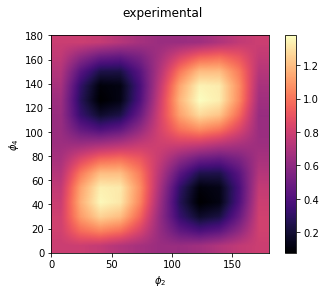

In [4]:
I_experimental=experimental_dict['intensities']
dibujar_2d_fitting(angles_1_e, angles_4_e, I_experimental, title='experimental')

## Parte numérica

In [5]:
#Light source: circular polarization
param_u0, u0 =get_light_parameters()
[amplitude, angle, phase]=param_u0
print(u0)

[[ 3.5431]
 [-0.0246]
 [ 0.0126]
 [ 3.5429]]


## Definición de funcion de ajuste

In [6]:
pol_dicts =get_polarimeter_parameters(kind='exp')
print(pol_dicts)
pol1,pol2,pol3,pol4 = pol_dicts
P1_0,P2_0,P3_0,P4_0=polarimeter_matrices(pol_dicts, angles=[0,0,0,0])
theta_1_ini = pol1['theta_axis']
theta_4_ini = pol4['theta_axis']

[{'p0': 0.128068490426, 'p1': 0.934950416021, 'theta_axis': 0.048659779545601904}, {'a': 1, 'theta_axis': 0.7780084393445043, 'b': 1, 'delta': 1.3854423602330987}, {'a': 1, 'theta_axis': 2.2996981823052884, 'b': 1, 'delta': 1.3854423602330987}, {'p0': 0.128068490426, 'p1': 0.934950416021, 'theta_axis': 2.8253389931284207}]


In [7]:
def get_intensity_numerical_simple(par_fitting, angles_1, angles_4, u0):
    """
    par_fitting son los parámetros de optimización, en este caso
        angle_1, angle_2, angle_4, p1, p0, a, b, delta=par_fitting
    """
    
    a,b, delta, angle_2_pol=par_fitting
    
    P1=P1_0
    P2=diattenuating_retarder(p1=a, p2=b, phase=delta, theta=angle_2_pol)
    P4=P4_0
       
    Angles_1, Angles_4 = sp.meshgrid(angles_1, angles_4)
    intensity_numerical=sp.zeros_like(Angles_1, dtype=float)

    for i1, angle_1 in enumerate(angles_1):
        P1_r =rotate_mueller(P1, angle_1)
        for i4, angle_4 in enumerate(angles_4):
            P4_r =rotate_mueller(P4, angle_4)
            intensity_numerical[i4,i1]=intensity(P4_r*P2*P1_r*u0)
            
    return intensity_numerical

In [9]:
def err_func(par_error, angles_1_e, angles_4_e, u0,I_experimental):
    I_theory=get_intensity_numerical_simple(par_error, angles_1_e, angles_4_e, u0)
    return (abs(I_theory -I_experimental ).flatten())

has_example=False
if has_example:
    par_example=[1,1, 90*degrees, 40*degrees]
    error=err_func(par_example, angles_1_e, angles_4_e, u0,I_experimental)
    print(error.mean())

In [10]:
params_1_ini = np.array([1,1,90*degrees,30*degrees]) # Initial guess for the parameters
params_1_fin, success = optimize.leastsq(err_func, params_1_ini, 
                                         args=(angles_1_e, angles_4_e, u0, I_experimental))

In [11]:
print("a={}, b={}, delta={}º, angle={}º".format(params_1_fin[0],params_1_fin[1],
                                              params_1_fin[2]/degrees, params_1_fin[3]/degrees))

a=1.00470641604, b=1.00957905941, delta=79.3828577781º, angle=42.64433084º


0.114229608293


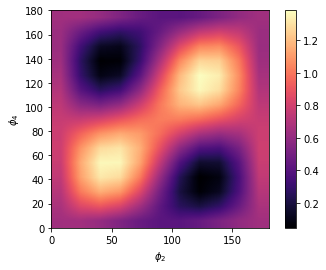

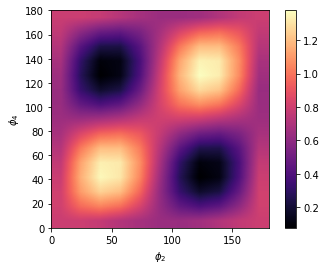

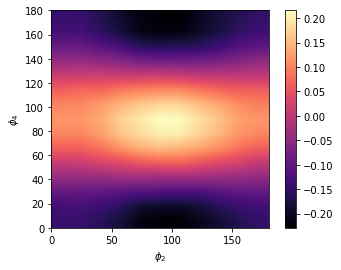

In [12]:
I_best=get_intensity_numerical_simple(params_1_fin, angles_1_e, angles_4_e, u0)

residuals=I_best-I_experimental
print(sp.mean(abs(residuals)))

dibujar_2d_fitting(angles_1_e, angles_4_e, I_best)
dibujar_2d_fitting(angles_1_e, angles_4_e, I_experimental)
dibujar_2d_fitting(angles_1_e, angles_4_e, residuals )